## Chapter 16 - Metric-Predicted Variable on One or Two Groups

- [16.1 - Estimating the mean and standard deviation of a normal distribution](#16.1---Estimating-the-mean-and-standard-deviation-of-a-normal-distribution)
- [16.2 - Outliers and robust estimation: the t distribution](#16.2---Outliers-and-robust-estimation:-the-t-distribution)
- [16.3 - Two Groups](#16.2---Two-Groups)


In [38]:
import pandas as pd
import numpy as np
import scipy.stats as stats
np.seterr(divide = 'ignore') 
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from scipy.stats import norm, t
from IPython.display import Image

# %matplotlib inline
# plt.style.use('seaborn-white')

color = '#87ceeb'

In [2]:
%load_ext watermark
%watermark -p pandas,numpy,pymc3,matplotlib,seaborn,scipy

pandas    : 1.2.1
numpy     : 1.19.5
pymc3     : 3.11.0
matplotlib: 3.3.3
seaborn   : 0.11.1
scipy     : 1.6.0



### Data
- IQ scores from two groups.
- The two groups are of categorical data type.

In [3]:
df = pd.read_csv('data/TwoGroupIQ.csv', dtype={'Group':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Score   120 non-null    int64   
 1   Group   120 non-null    category
dtypes: category(1), int64(1)
memory usage: 1.3 KB


In [4]:
df.head(2)

,Score,Group
0,102,Smart Drug
1,107,Smart Drug


In [5]:
# Mean and STD for each group
df.groupby('Group').aggregate(['mean', 'std', 'sum'])

Score                 
                  mean        std   sum
Group                                  
Placebo     100.035088  17.894497  5702
Smart Drug  107.841270  25.445201  6794

In [6]:
# Mean and STD for each group
sum(df.Group == 'Placebo'), sum(df.Group == 'Smart Drug')

(57, 63)

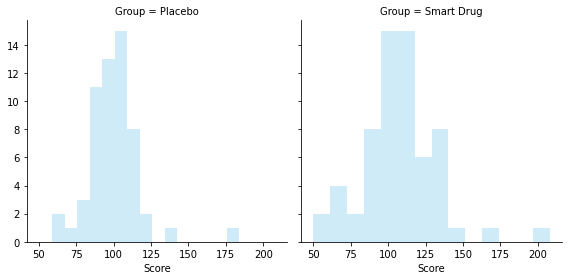

In [7]:
# see: https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
fg = sns.FacetGrid(df, col='Group', height=4)
fg.map(sns.distplot, 'Score', kde=False, color='#87ceeb');

#### Data for 16.1

In [8]:
# We are only interested in the scores of group 'Smart Drug'
y = df['Score'][df.Group == 'Smart Drug']

### 16.1 - Estimating the mean and standard deviation of a normal distribution

#### Model (Kruschke, 2015)

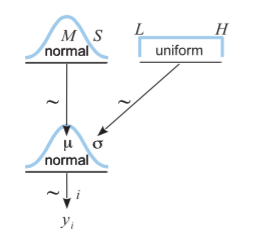

In [9]:
Image('images/fig16_2.png', width=400)

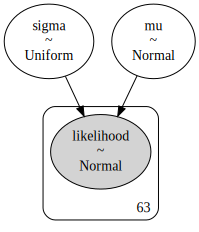

In [10]:
# sudo apt install graphviz

with pm.Model() as model:
    mu = pm.Normal('mu', y.mean(), sd=y.std())
    sigma = pm.Uniform('sigma', y.std()/1000, y.std()*1000)
    
    # PyMC's Normal likelihood can take either precision or standard deviation as an argument.
    likelihood = pm.Normal('likelihood', mu, sd=sigma, observed=y)

pm.model_to_graphviz(model)

In [11]:
with model:
    trace = pm.sample(4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 3 seconds.


In [12]:
trace

<MultiTrace: 4 chains, 4000 iterations, 3 variables>

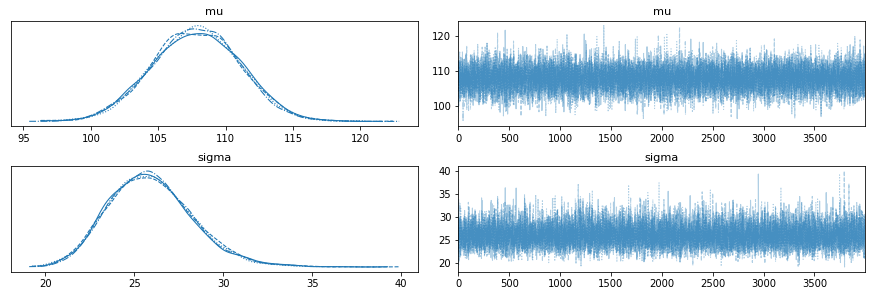

In [13]:
az.plot_trace(trace);

#### Figure 16.3

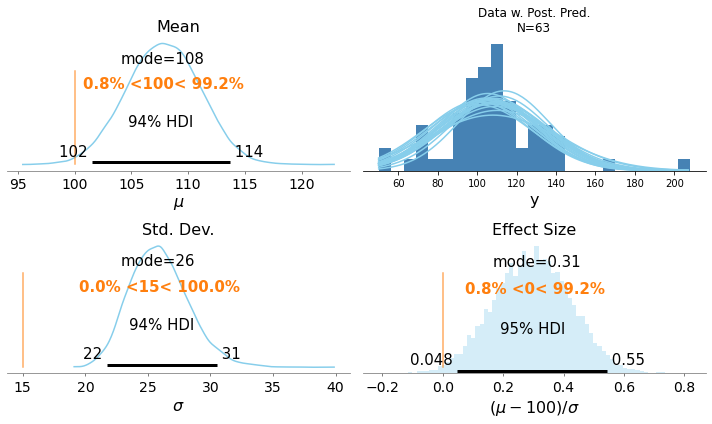

In [14]:
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2,2, figsize=(10,6))

font_d = {'size':16}

# Upper left
az.plot_posterior(trace['mu'], point_estimate='mode', ref_val=100, ax=ax1, color=color)
ax1.set_xlabel('$\mu$', fontdict=font_d)
ax1.set_title('Mean', fontdict=font_d)

# Upper right
tr_len = len(trace)
# Plot only 20 posterior prediction curves. 
n_curves = 20
# Create an index of length 20 with which we step through the trace.
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
x_range = np.arange(y.min(), y.max())
x = np.tile(x_range.reshape(-1,1), (1,20))

ax2.hist(y, bins=25, density=True, color='steelblue')
ax2.plot(x, norm.pdf(x, trace['mu'][stepIdxVec], trace['sigma'][stepIdxVec]), c=color)
ax2.set_xlabel('y', fontdict=font_d)
ax2.set_title('Data w. Post. Pred.\nN=63')
[ax2.spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
ax2.yaxis.set_visible(False)

# Lower left
az.plot_posterior(trace['sigma'], point_estimate='mode', ref_val=15, ax=ax3, color=color)
ax3.set_xlabel('$\sigma$', fontdict=font_d)
ax3.set_title('Std. Dev.', fontdict=font_d)

# Lower right
az.plot_posterior((trace['mu']-100)/trace['sigma'], point_estimate='mode', ref_val=0,
                  hdi_prob=0.95,
                  ax=ax4, color=color, kind='hist')
ax4.set_title('Effect Size', fontdict=font_d)
ax4.set_xlabel('$(\mu - 100)/\sigma$', fontdict=font_d)

plt.tight_layout();

### 16.2 - Outliers and robust estimation: the t distribution

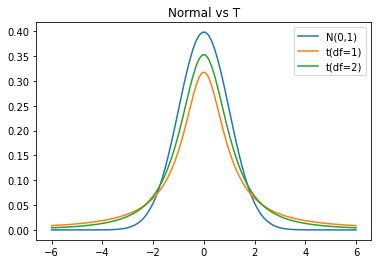

In [15]:
import scipy.stats as stats
x=np.linspace(-6,6,100)
plt.plot(x, stats.norm(loc=0,scale=1).pdf(x), label='N(0,1)')
plt.plot(x, stats.t(df=1, loc=0, scale=1).pdf(x), label='t(df=1)')
plt.plot(x, stats.t(df=2, loc=0, scale=1).pdf(x), label='t(df=2)')
# plt.plot(x, stats.t(df=100, loc=0, scale=1).pdf(x), label='t(df=100)')
plt.title('Normal vs T')
plt.legend();

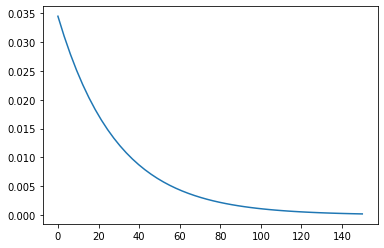

In [16]:
scale=29. # intended mean
x = np.linspace(0, 150)
z = np.linspace(0, 2.5, 100)
dexp = stats.expon(scale=scale)
plt.plot(x, dexp.pdf(x));

In [17]:
s = 1 + dexp.rvs(100000);
ls = np.log10(s)

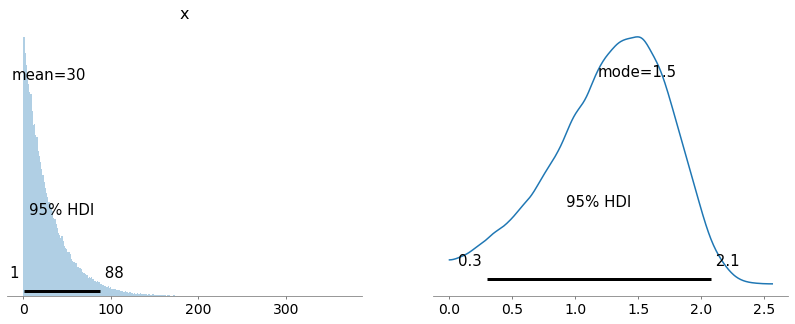

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,5))
az.plot_posterior(s, ax=ax1, kind='hist', hdi_prob=.95)
az.plot_posterior(ls, ax=ax2, hdi_prob=.95, point_estimate='mode');
ax2.set_title(None);

#### Model

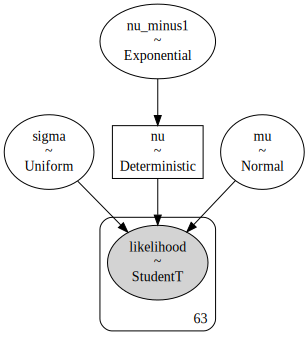

In [19]:
with pm.Model() as model2:
    mu = pm.Normal('mu', y.mean(), sd=y.std())
    sigma = pm.Uniform('sigma', y.std()/1000, y.std()*1000)
    nu_minus1 = pm.Exponential('nu_minus1', 1/29)
    nu = pm.Deterministic('nu', nu_minus1+1)
    
    likelihood = pm.StudentT('likelihood', nu,  mu, sd=sigma, observed=y)

pm.model_to_graphviz(model2)

In [20]:
with model2:
    trace2 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus1, sigma, mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.


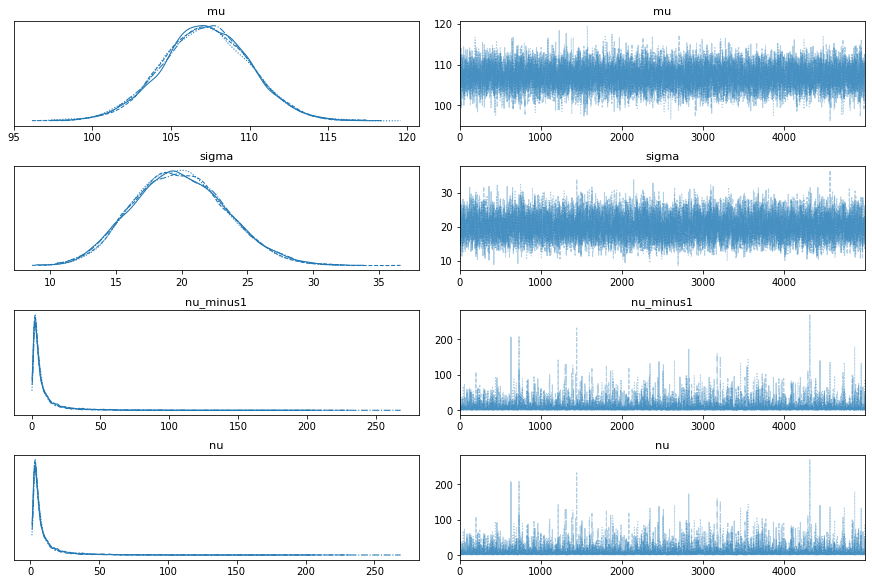

In [21]:
az.plot_trace(trace2);

#### Figure 16.9

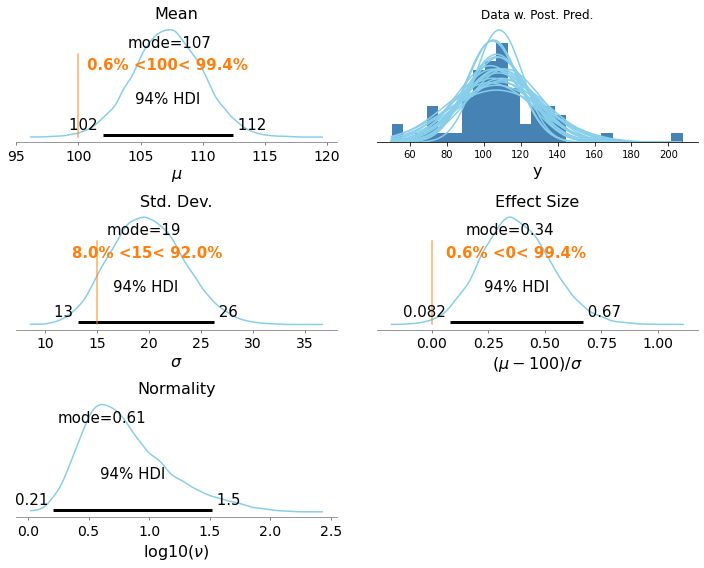

In [22]:
fig, [(ax1, ax2), (ax3, ax4), (ax5, ax6)] = plt.subplots(3,2, figsize=(10,8))

# Upper left
az.plot_posterior(trace2['mu'], point_estimate='mode', ref_val=100, ax=ax1, color=color)
ax1.set_xlabel('$\mu$', fontdict=font_d)
ax1.set_title('Mean', fontdict=font_d)

# Upper right
tr_len = len(trace)
n_curves = 20
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
x_range = np.arange(y.min(), y.max())
x = np.tile(x_range.reshape(-1,1), (1,20))

ax2.hist(y, bins=25, density=True, color='steelblue')
ax2.plot(x, norm.pdf(x, trace2['mu'][stepIdxVec], trace2['sigma'][stepIdxVec]), c='#87ceeb')
ax2.set_xlabel('y', fontdict=font_d)
ax2.set_title('Data w. Post. Pred.')
[ax2.spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
ax2.yaxis.set_visible(False)

# Middle left
az.plot_posterior(trace2['sigma'], point_estimate='mode', ref_val=15, ax=ax3, color=color)
ax3.set_xlabel('$\sigma$', fontdict=font_d)
ax3.set_title('Std. Dev.', fontdict=font_d)

# Middle right
az.plot_posterior((trace2['mu']-100)/trace2['sigma'], point_estimate='mode', ref_val=0,
                  ax=ax4, color=color)
ax4.set_title('Effect Size', fontdict=font_d)
ax4.set_xlabel('$(\mu - 100)/\sigma$', fontdict=font_d)

# Lower left
az.plot_posterior(np.log10(trace2['nu']), point_estimate='mode', ax=ax5, color=color)
ax5.set_title('Normality', fontdict=font_d)
ax5.set_xlabel(r'log10($\nu$)', fontdict=font_d)

plt.tight_layout();
ax6.set_visible(False)

In [23]:
nu_mode = az.plots.plot_utils.calculate_point_estimate('mode', np.log10(trace2['nu']))
nu_mode, np.power(10, nu_mode)

(0.6097743614233788, 4.071686775301119)

#### Figure 16.8

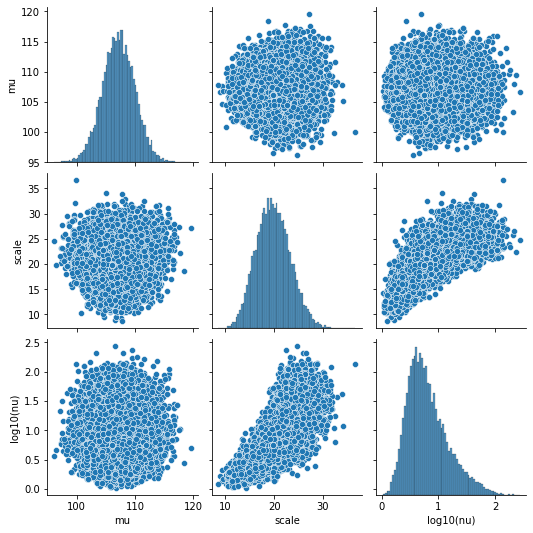

In [24]:
imsi = pd.DataFrame({'mu': trace2['mu'], 'scale': trace2['sigma'], 'log10(nu)': np.log10(trace2['nu'])})
sns.pairplot(imsi);

In [25]:
# correlation
imsi.corr()

,mu,scale,log10(nu)
mu,1.000000,0.022378,0.033469
scale,0.022378,1.000000,0.733864
log10(nu),0.033469,0.733864,1.000000


Notice the strong positive correlation of scale ($\sigma$) and \$log_{10}(\nu)$

## 16.3 - Two Groups

#### Model (Kruschke, 2015)

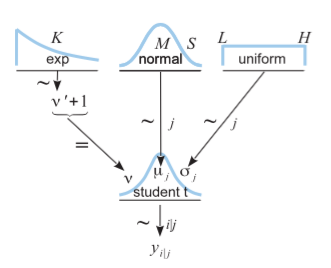

In [26]:
Image('images/fig16_11.png', width=400)

#### Data for Two Group Comparison
- will compare the groups of two categories
- Effect size (here, it is Cohen's d. See [https://en.wikipedia.org/wiki/Effect_size](https://en.wikipedia.org/wiki/Effect_size))
    $$
        d = \frac{\mu_2 - \mu_1}{s}, \quad\quad
        s = \sqrt{\frac{(n_1 - 1) s_1^2 + (n_2-2) s_2^2}{n_1 + n_2 - 2}}
    $$
    where $s$ is the pooled standard deviation.
    $$
        \mbox{effect size} = \frac{\mbox{mean of test group} - \mbox{mean of control group}}{std}
    $$
    - from [It's the Effect Size, Stupid What effect size is and why it is important](https://www.leeds.ac.uk/educol/documents/00002182.htm#:~:text=Effect%20size%20is%20a%20simple,confounding%20this%20with%20sample%20size.&text=A%20number%20of%20alternative%20measures%20of%20effect%20size%20are%20described.)
        - Effect size is a simple way of quantifying the difference between two groups that has many advantages over the use of tests of statistical significance alone. 
        - Effect size emphasises the size of the difference rather than confounding this with sample size.
        - The paper is w.r.t Frequentist's point of view. But we can compute its posterior distribution thanks to the development of PPL.

In [27]:
grp_idx = df.Group.cat.codes.values
grp_codes = df.Group.cat.categories
n_grps = grp_codes.size
print('grp_idx:  ', grp_idx)
print('grp_codes:', grp_codes)
print('n_grps:   ', n_grps)

grp_idx:   [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
grp_codes: Index(['Placebo', 'Smart Drug'], dtype='object')
n_grps:    2


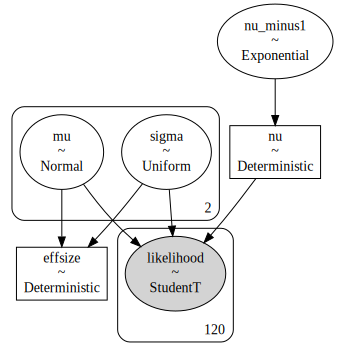

In [28]:
with pm.Model() as model3:
    mu = pm.Normal('mu', df.Score.mean(), sd=df.Score.std(), shape=n_grps)  # loc of StudentT
    sigma = pm.Uniform('sigma', df.Score.std()/1000, df.Score.std()*1000, shape=n_grps)  # scale of StudentT
    nu_minus1 = pm.Exponential('nu_minus1', 1/29)  # degree of freedom, normality >= 1
    nu = pm.Deterministic('nu', nu_minus1+1)
    
    effsize = pm.Deterministic('effsize', pm.math.dot(mu, [-1, 1]) / pm.math.sqrt( pm.math.dot(sigma, sigma)/2 ) )
    likelihood = pm.StudentT('likelihood', nu,  mu[grp_idx], sd=sigma[grp_idx], observed=df.Score)
#
pm.model_to_graphviz(model3)

In [29]:
with model3:
    trace3 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus1, sigma, mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.


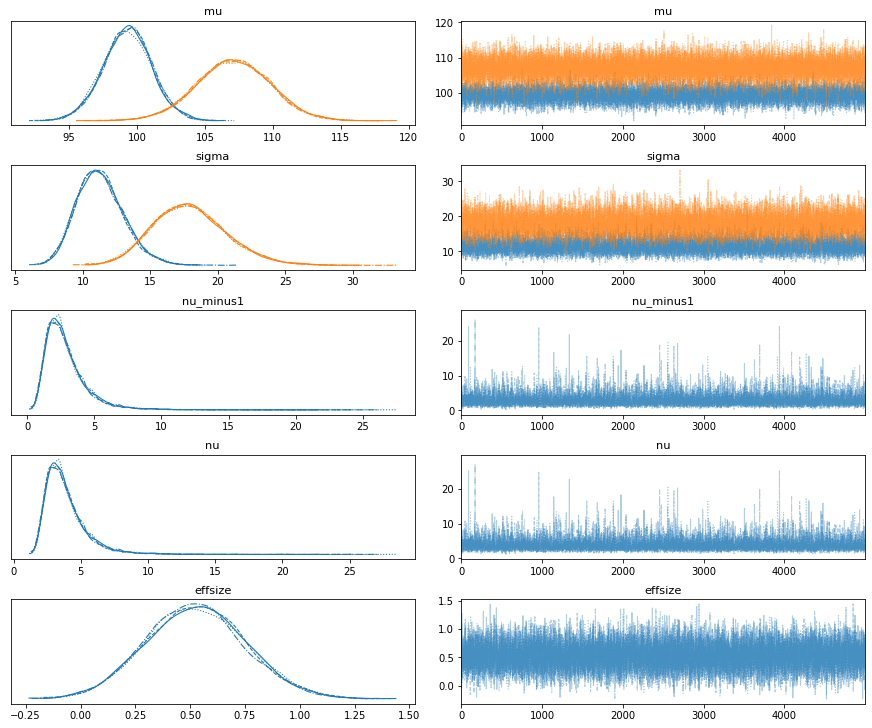

In [30]:
az.plot_trace(trace3);

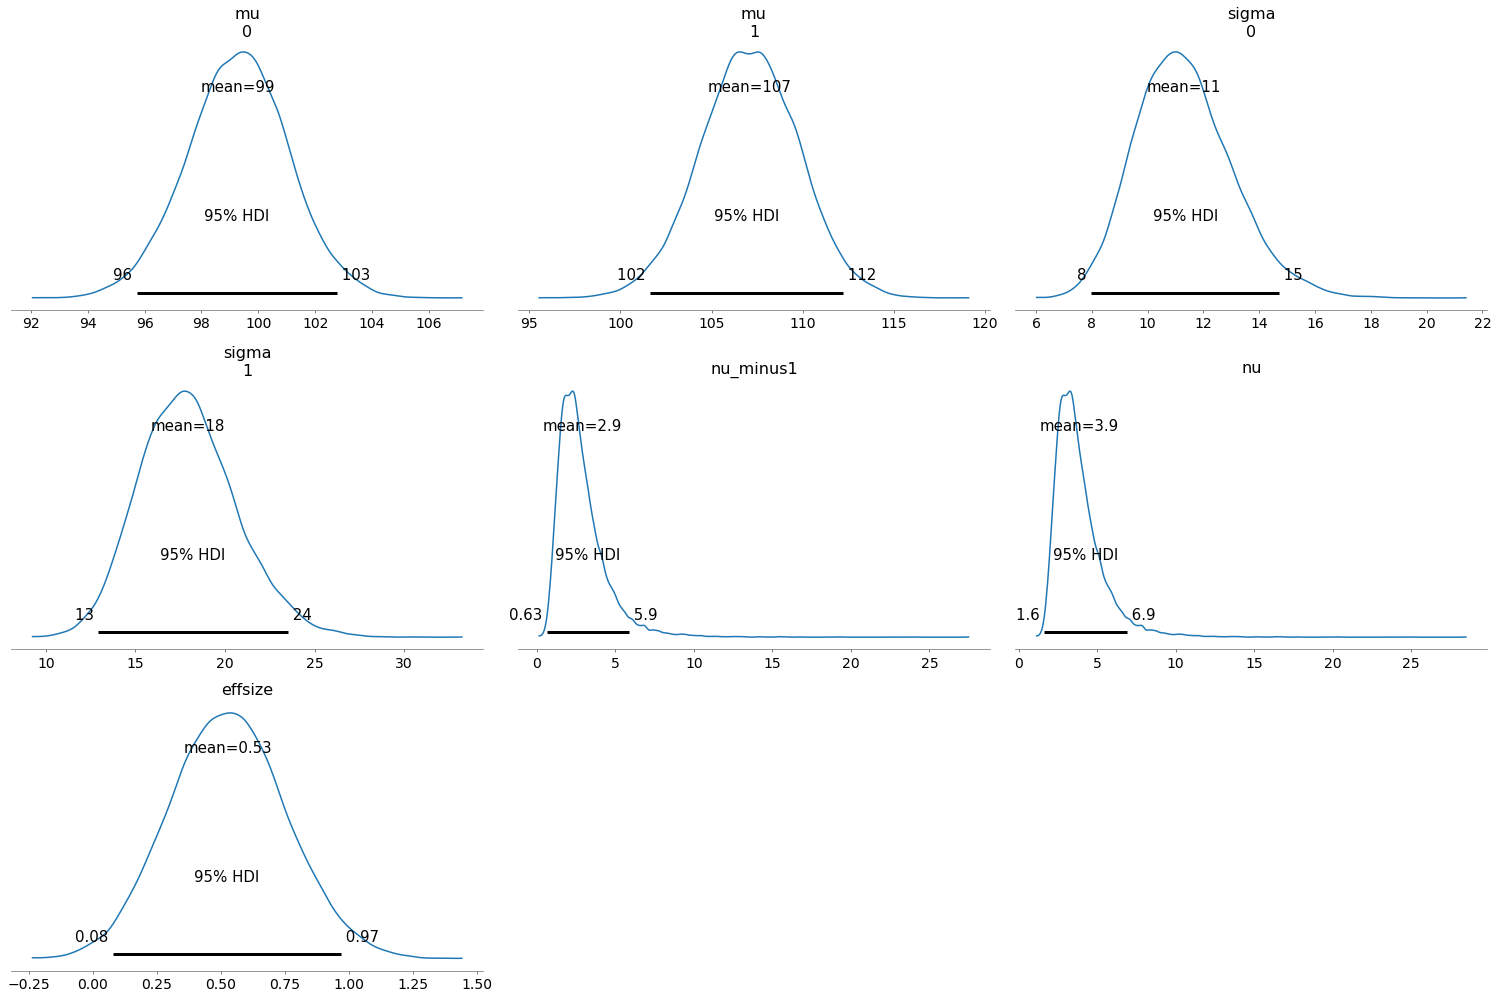

In [31]:
az.plot_posterior(trace3, hdi_prob=0.95);

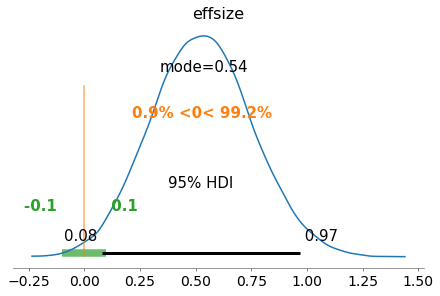

In [32]:
az.plot_posterior(trace3, hdi_prob=0.95, var_names=['effsize'], point_estimate='mode', ref_val=0, rope=[-.1, .1]);

In [33]:
es = trace3['effsize']
np.array([sum(es<-.1) , sum((-.1 < es) & (es < .1)) , sum(es > .1)]) * 100 / len(es)

array([ 0.18 ,  2.505, 97.315])

#### Figure 16.12

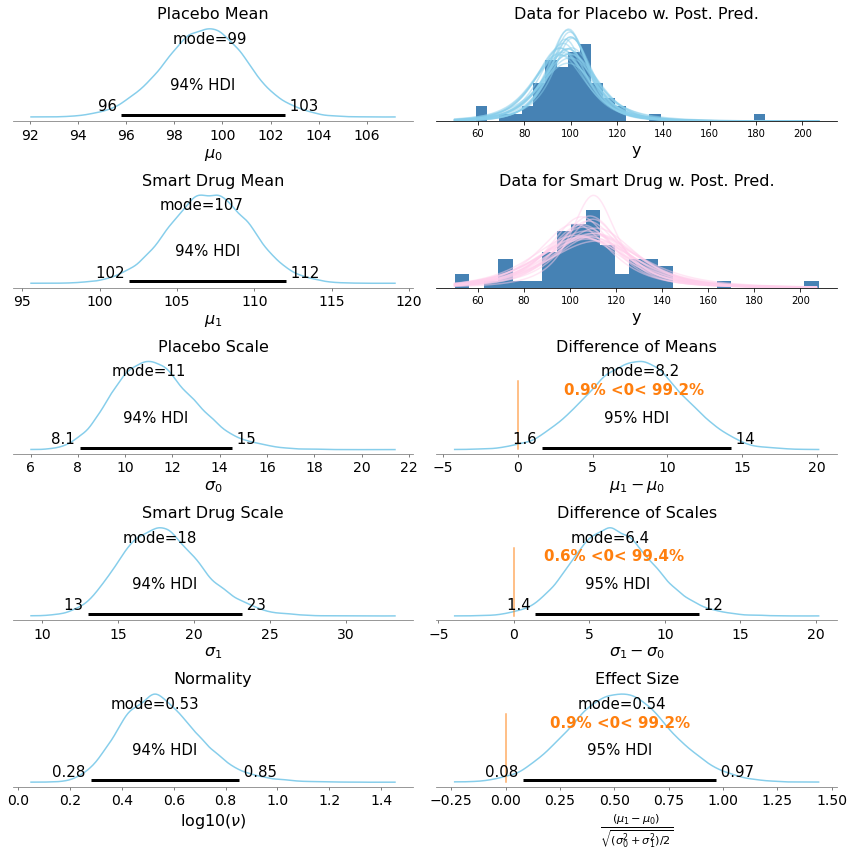

In [34]:
tr3_mu0 = trace3['mu'][:,0]
tr3_mu1 = trace3['mu'][:,1]
tr3_sigma0 = trace3['sigma'][:,0]
tr3_sigma1 = trace3['sigma'][:,1]
tr3_nu = np.log10(trace3['nu'])

fig, axes = plt.subplots(5,2, figsize=(12, 12))

# Left column figs
l_trace_vars = (tr3_mu0, tr3_mu1, tr3_sigma0, tr3_sigma1, tr3_nu)
l_axes_idx = np.arange(5)
l_xlabels = ('$\mu_0$', '$\mu_1$', '$\sigma_0$', '$\sigma_1$', r'log10($\nu$)')
l_titles = ('Placebo Mean', 'Smart Drug Mean', 'Placebo Scale', 'Smart Drug Scale', 'Normality')

for var, ax_i, xlabel, title in zip(l_trace_vars, l_axes_idx, l_xlabels, l_titles): 
    az.plot_posterior(var, point_estimate='mode', ax=axes[ax_i,0], color=color)
    axes[ax_i,0].set_xlabel(xlabel, font_d)
    axes[ax_i,0].set_title(title, font_d)

# Right column figs
tr_len = len(trace3)
n_curves = 20
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
x_range = np.arange(df.Score.min(), df.Score.max())
x = np.tile(x_range.reshape(-1,1), (1,20))

# 1
axes[0,1].hist(df.Score[df.Group == 'Placebo'], bins=25, density=True, color='steelblue')
axes[0,1].plot(x, t.pdf(x, loc=tr3_mu0[stepIdxVec], scale=tr3_sigma0[stepIdxVec],
                        df=trace3['nu'][stepIdxVec]), c='#87ceeb', alpha=.5)
axes[0,1].set_xlabel('y', font_d)
[axes[0,1].spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
axes[0,1].yaxis.set_visible(False)
axes[0,1].set_title('Data for Placebo w. Post. Pred.', font_d)

# 2
axes[1,1].hist(df.Score[df.Group == 'Smart Drug'], bins=25, density=True, color='steelblue')
axes[1,1].plot(x, t.pdf(x, loc=tr3_mu1[stepIdxVec], scale=tr3_sigma1[stepIdxVec],
                        df=trace3['nu'][stepIdxVec]), c='#ffceeb', alpha=.5)
axes[1,1].set_xlabel('y', font_d)
[axes[1,1].spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
axes[1,1].yaxis.set_visible(False)
axes[1,1].set_title('Data for Smart Drug w. Post. Pred.', font_d)

# 3-5
r_vars = (tr3_mu1-tr3_mu0,
          tr3_sigma1-tr3_sigma0,
          (tr3_mu1-tr3_mu0)/np.sqrt((tr3_sigma0**2+tr3_sigma1**2)/2))
r_axes_idx = np.arange(start=2, stop=5)
r_xlabels = ('$\mu_1 - \mu_0$',
             '$\sigma_1 - \sigma_0$',
             r'$\frac{(\mu_1-\mu_0)}{\sqrt{(\sigma_0^2+\sigma_1^2)/2}}$')
r_titles = ('Difference of Means',
            'Difference of Scales',
            'Effect Size')

for var, ax_i, xlabel, title in zip(r_vars, r_axes_idx, r_xlabels, r_titles):
    az.plot_posterior(var, point_estimate='mode', ref_val=0, hdi_prob=.95, ax=axes[ax_i,1], color=color)
    axes[ax_i,1].set_xlabel(xlabel, font_d)
    axes[ax_i,1].set_title(title, font_d)

plt.tight_layout();

In [35]:
trace3.varnames

['mu',
 'sigma_interval__',
 'nu_minus1_log__',
 'sigma',
 'nu_minus1',
 'nu',
 'effsize']

In [36]:
trace3['mu'][:,0].size

20000

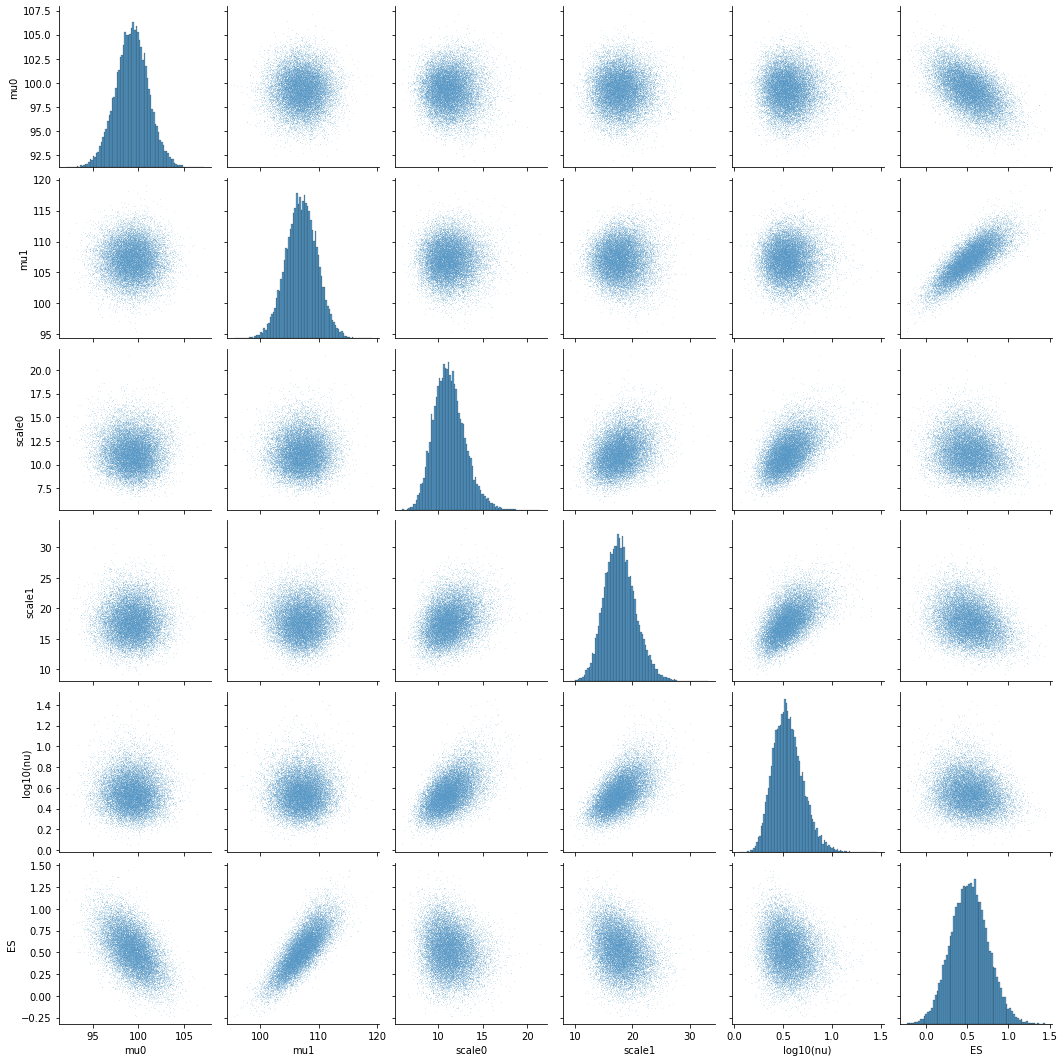

In [37]:
imsi = pd.DataFrame({'mu0': trace3['mu'][:,0], 'mu1' : trace3['mu'][:,1], 
                     'scale0': trace3['sigma'][:,0], 'scale1': trace3['sigma'][:,1], 
                     'log10(nu)': np.log10(trace3['nu']),
                     'ES': trace3['effsize']
                    })
sns.pairplot(imsi, plot_kws={'s': .2});

End.

##### 16.3.1 Analysis by NHST

In [45]:
grouped = df.groupby(df.Group)
grouped.get_group('Placebo')[:2]

,Score,Group
63,109,Placebo
64,98,Placebo


In [53]:
stats.ttest_ind(grouped.get_group('Placebo').Score, grouped.get_group('Smart Drug').Score,
               equal_var=False)

Ttest_indResult(statistic=-1.9579876350511547, pvalue=0.05273105236398135)

In [55]:
imsi = [grouped.get_group(s).Score for s in df.Group.cat.categories]
# print(imsi)
stats.ttest_ind(imsi[0], imsi[1],
               equal_var=False)

Ttest_indResult(statistic=-1.9579876350511547, pvalue=0.05273105236398135)

In [56]:
df.Group.cat.categories

Index(['Placebo', 'Smart Drug'], dtype='object')